# MSP Simulation Example - Nonlinear Resistive Companion

## Sample Circuit

<img src="NL_RC.png" width="500" align="left">

$E$=$10 V$, $R_S$=$1 \Omega$, $C$=$10 uF$  
$i_R = g(v_R)= \frac{v_R^2}{R_{NL}} $  
$R_{NL}$=$1 \Omega$  

## Simulation Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Circuit parameters
E=10 
Rs=1
C=1e-5

# Nonlinear resistor: U^2 = R_NL*I
R_NL=1

# Total simulation time
T_total=0.001

# Simulation time step
Ts = 1e-6
npoint = int(T_total/Ts)

# Newton-Raphson method
# Max number of iterations
ite_max=100

# error tolerance
tol=1e-4

# Conductance for Rs
Gs=1/Rs

#Conductance of the non-linear element for j-th iteration of Newton-Raphson method
#U^2 = R_NL*I
#I=U^2/R_NL
#dI/dU=2*U/R_NL

# Node voltage vector
v1_trap = np.zeros(npoint)
v2_trap = np.zeros(npoint)

# Current
i_trap = np.zeros(npoint)

# Number of iterations in each time step
num_iter = np.zeros(npoint)

## Set Initial Conditions
- Precondition: $ u_C(0)=0 $  
- Analytic solution: $ \frac{e_1(0)^2}{R_{NL}} = \frac{E - e_1(0)}{R_s} $ $\Rightarrow R_s e_1(0)^2 + R_{NL} \cdot e_1(0) - R_{NL} E = 0 $

In [2]:
v1_trap[0] = (-R_NL + np.sqrt(R_NL^2+4*Rs*E*R_NL))/(2*Rs)
i_trap[0] = np.square(v1_trap[0])/R_NL
v2_trap[0] = 0

print("Calculated initial conditions: \n")
print("e1(0) = " + str(v1_trap[0]))
print("e2(0) = " + str(v2_trap[0]))
print("iR(0) = " + str(i_trap[0]))

Calculated initial conditions: 

e1(0) = 2.778719262151
e2(0) = 0.0
iR(0) = 7.721280737848999


## Numerical Integration and Newton-Raphson Loop
- Application of Trapezoidal integration method

In [3]:
# DC equivalent of capacitor
Gc=(2*C)/Ts

# Numerical integration loop
for i in range(1, npoint):
    # Update DC equivalent of capacitor
    Ac=i_trap[i-1]+2*C/Ts*(v2_trap[i-1])

    #initial condition to start the Newton-Raphson 
    v1_new=v1_trap[i-1]+0.1
    v2_new=v2_trap[i-1]
    #ensures the while condition for start
    v1_old=v1_new+5*tol
    v2_old=v2_new+5*tol

    num_iter[i]=1

    #Newton-Raphston method loop
    #Save example of set of NR iterations for plotting
    Ts_index = 10 #index of time step in which we save iterations
    if i==Ts_index:
        V_exmp_NR = []
        I_exmp_NR = []

    while num_iter[i]<=ite_max and (abs(v1_old-v1_new)>=tol or abs(v2_old-v2_new)>=tol):
        #linearization of the NL element around the operating point (=di/du)
        delta_v=v1_new-v2_new
        G_NL = 2*delta_v/R_NL 
        J_NL = np.square(delta_v)/R_NL-G_NL*delta_v

        #admittance matrix
        Gn=np.array([[  Gs+G_NL,   -G_NL],
                     [  -G_NL,     G_NL+Gc]])

        #source vector
        Jn=np.array([E/Rs-J_NL,
                     J_NL+Ac])

        new_v=np.linalg.solve(Gn,Jn)

        v1_old=v1_new
        v2_old=v2_new

        v1_new=new_v[0]
        v2_new=new_v[1]

        num_iter[i]=num_iter[i]+1

        #Save example of set of NR iterations for plotting
        if i==Ts_index:
            V_exmp_NR.append(v1_new-v2_new)
            I_exmp_NR.append(-Ac+v2_new*Gc)

    #operating point found -> assignement in the solution matrix
    v1_trap[i]=v1_new
    v2_trap[i]=v2_new

    # post step
    i_trap[i] = -Ac + v2_trap[i]*Gc

## Simulation Results
### Capacitor Voltage

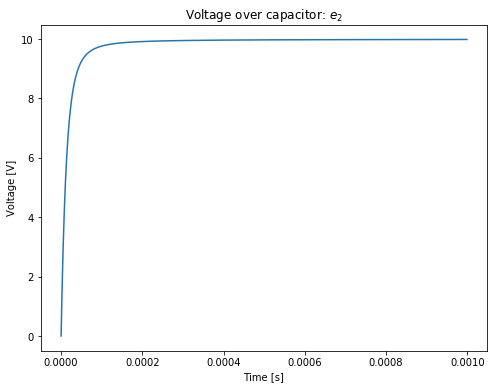

In [4]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(0,T_total-Ts,Ts),v2_trap)
plt.title('Voltage over capacitor: $ e_{2} $')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.show()

## Capacitor Current

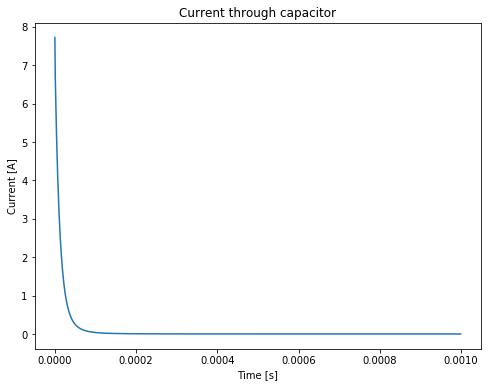

In [5]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(0,T_total-Ts,Ts),i_trap)
plt.title('Current through capacitor')
plt.xlabel('Time [s]')
plt.ylabel('Current [A]')
plt.show()

## I-V Characteristic of Nonlinear Resistor

In [6]:
v_R_NL = v1_trap - v2_trap
plt.figure(figsize=(8,6))
plt.plot(v_R_NL,i_trap)
plt.xlabel('Voltage [V]')
plt.ylabel('Current [A]')
plt.plot(V_exmp_NR,I_exmp_NR, 'x') 
plt.legend(['I-V characteristic of nonlinear resistor','N-R iterations within one sim time step'])
plt.show()

# Number of Newton-Raphson Iterations

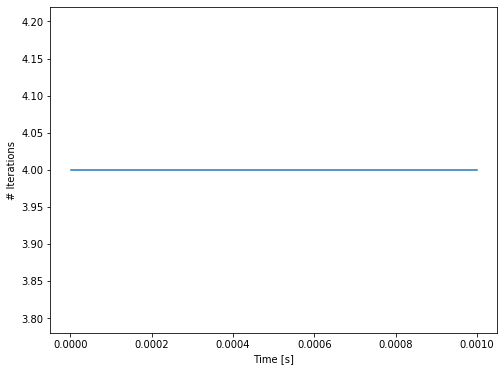

In [7]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(Ts,T_total-Ts,Ts),num_iter[1:])
plt.xlabel('Time [s]')
plt.ylabel('# Iterations')
plt.show()